Based on https://github.com/naokishibuya/car-finding-lane-lines

In [69]:
import matplotlib.pyplot as plt
import cv2
import os, glob 
import copy, math
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
g_silent = False
g_images_dir = ['test_images', 'more_images'][1]
g_dbg_tags = ['contour']
g_dbg_indices = range(3,4)
g_use_roi = False
g_white_low = [0,200,0]

In [70]:
def show_images_(images, cmap = None):
    if len(images) == 0:
        return
    cols = 2
    rows = (len(images)+1)//cols
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def show_images(images, tag, cmap=None):
    if g_dbg_tags is None or tag in g_dbg_tags:
        show_images_([images[x] for x in range(len(images)) if g_dbg_indices is None or x in g_dbg_indices], cmap)
src_images = [plt.imread(path) for path in glob.glob('data/{}/*.jpg'.format(g_images_dir))]
show_images(src_images, 'src')

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
hls_images = list(map(convert_hls, src_images))
show_images(hls_images, 'hls')

def select_white_yellow(hls_image):
    converted = hls_image
    # white color mask
    lower = np.uint8(g_white_low)
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(hls_image, hls_image, mask = mask)

white_yellow_images = list(map(select_white_yellow, hls_images))
show_images(white_yellow_images, 'white_yellow')

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))
show_images(gray_images, 'gray')

def apply_smoothing(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images, 'blurred')

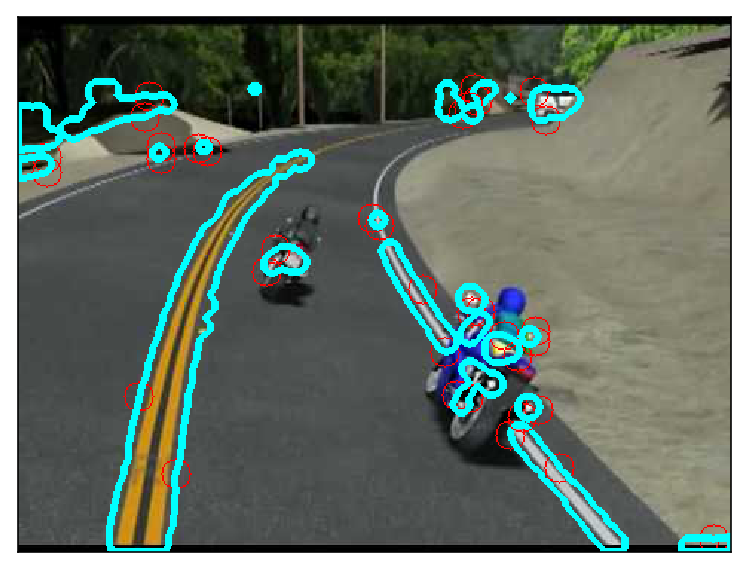

In [71]:
contour_images = []
for i, img in enumerate(blurred_images):
    img2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if i not in g_dbg_indices:
        contour_images.append(img2)
        continue
    def gen_contour_dirs(pts, stride = 6):
        # use statistics for a robust version of this
        if len(pts) < stride:
            return None
        dirs = []
        for i in range(len(pts)):
            p0 = pts[i]; p1 = pts[(i+stride) % len(pts)];
            dirs.append(np.subtract(p1, p0))
        return dirs
    def find_opposing_point(pts, dirs, pi0):
        min_pi = -1; min_dist = 0.0;
        for pi in [x%len(pts) for x in range(pi0 + int(0.2*len(pts)), pi0 + int(0.8*len(pts)))]:
            #print pi, dirs[pi0], dirs[pi]
            if np.dot(dirs[pi], dirs[pi0]) < -0.5:
                pi_dist = np.linalg.norm(np.subtract(pts[pi0], pts[pi]))
                if min_pi == -1 or pi_dist < min_dist:
                    min_pi = pi; min_dist = pi_dist
        return min_pi
    def contour_is_lane(contour_pts):
        return True
    tgt = copy.copy(src_images[i])
    for contour in [x for x in contours[:20]]:
        contour_pts = [x[0] for x in contour] # I don't get this...
        contour_dirs = gen_contour_dirs(contour_pts, 6)
        is_lane = contour_is_lane(contour_pts)
        if contour_dirs is not None:
            pi0 = np.random.randint(len(contour_pts)-1); pi1 = find_opposing_point(contour_pts, contour_dirs, pi0);
            if pi1 != -1:
                cv2.circle(tgt, tuple(contour_pts[pi0]), 10, [255,0,0])
                cv2.circle(tgt, tuple(contour_pts[pi1]), 10, [255,0,0])
        col = [int(x*255) for x in np.random.rand(3,1)]
        col = [0,255,255] if is_lane else [255,0,0]
        tgt = cv2.drawContours(tgt, [contour], -1, col, 3)
    contour_images.append(tgt)
show_images(contour_images, 'contour')